# 📦 Stage 3: 発注最適化分析

## 目的
**「いつ、どれだけ発注すべきか？」を科学的に決める**

このノートブックでは、適切な発注量を算出し、欠品と廃棄の両方を最小化します。

### 発注の2大リスク
1. **欠品リスク**: 発注が少なすぎて売り逃す → 売上機会損失
2. **廃棄リスク**: 発注が多すぎて売れ残る → 廃棄ロス・キャッシュフロー悪化

### 分析内容
1. **需要パターンの理解**
   - 曜日別・時期別の需要変動
   - トレンド（上昇/下降/横ばい）の把握

2. **適正在庫水準の算出**
   - 安全在庫の計算（欠品を防ぐ最低限の在庫）
   - 発注点の算出（この水準になったら発注する）

3. **発注量の最適化**
   - 商品別の推奨発注量
   - 曜日別の発注量調整係数

4. **需要予測モデル（簡易版）**
   - 移動平均法による予測
   - 季節性を考慮した予測

### 業務的な意義
- **発注担当**: 勘に頼らず、データで発注量を決められる
- **店長**: 廃棄ロスを減らし、利益率を向上させる
- **オーナー**: 在庫回転率を上げ、キャッシュフローを改善する

---

## 📦 1. 環境準備

In [ ]:
# 日本語フォント設定（共通モジュール）
import warnings
warnings.filterwarnings('ignore')

# よく使うライブラリを先に読み込む
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ウィジェットの有無を通知・フラグ化
try:
    import ipywidgets as widgets
    from IPython.display import display, HTML, clear_output
    WIDGETS_AVAILABLE = True
    print('✅ ipywidgets利用可能')
except Exception:
    WIDGETS_AVAILABLE = False
    print('⚠️ ipywidgets未インストール - 一部機能制限')

import font_setup
JP_FP = font_setup.setup_fonts(show_test=False)


In [2]:
import pandas as pd
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

## 📁 2. データ読み込み

In [3]:
file_path = 'output/06_final_enriched_20250701_20250930.csv'

print(f"📂 データ読み込み中: {file_path}")
df = pd.read_csv(file_path, encoding='utf-8-sig')
df['日付'] = pd.to_datetime(df['日付'])

print(f"\n✅ 読み込み完了")
print(f"   データ期間: {df['日付'].min().strftime('%Y-%m-%d')} 〜 {df['日付'].max().strftime('%Y-%m-%d')}")
print(f"   総商品数: {df['商品名'].nunique():,}商品")

📂 データ読み込み中: output/06_final_enriched_20250701_20250930.csv

✅ 読み込み完了
   データ期間: 2025-07-01 〜 2025-09-30
   総商品数: 1,864商品


## 📊 3. 需要パターンの分析

### 業務的な意義
商品の需要パターン（安定/変動が大きい）を理解し、発注戦略を決める

In [4]:
# 日次・商品別の売上数量を集計
daily_product_sales = df.groupby(['日付', '商品名']).agg({
    '売上数量': 'sum'
}).reset_index()

# 商品別の統計量を計算
product_stats = daily_product_sales.groupby('商品名')['売上数量'].agg([
    ('平均', 'mean'),
    ('標準偏差', 'std'),
    ('最小', 'min'),
    ('最大', 'max'),
    ('中央値', 'median')
]).reset_index()

# 変動係数（CV: Coefficient of Variation）を計算
# CV = 標準偏差 / 平均 → 需要の安定性を示す指標
product_stats['変動係数_CV'] = (product_stats['標準偏差'] / product_stats['平均']).round(2)

# CVによる需要パターン分類
def classify_demand_pattern(cv):
    if pd.isna(cv) or cv == np.inf:
        return '不明'
    elif cv < 0.3:
        return '安定'
    elif cv < 0.7:
        return '通常'
    else:
        return '変動大'

product_stats['需要パターン'] = product_stats['変動係数_CV'].apply(classify_demand_pattern)

# 上位20商品を表示
product_stats_sorted = product_stats.sort_values('平均', ascending=False)

print("="*60)
print("📊 商品別需要パターン分析（上位20商品）")
print("="*60)
print(product_stats_sorted.head(20).to_string(index=False))

print("\n" + "-"*60)
print("【変動係数（CV）の読み方】")
print("  CV < 0.3  → 需要が安定（発注しやすい）")
print("  CV 0.3-0.7 → 需要が通常の変動（標準的な発注）")
print("  CV > 0.7  → 需要変動が大きい（慎重に発注、安全在庫を多めに）")

# パターン別の商品数
pattern_counts = product_stats['需要パターン'].value_counts()
print("\n" + "-"*60)
print("【需要パターン別の商品数】")
for pattern, count in pattern_counts.items():
    print(f"  {pattern}: {count}商品 ({count/len(product_stats)*100:.1f}%)")

📊 商品別需要パターン分析（上位20商品）
                  商品名       平均   標準偏差  最小  最大  中央値  変動係数_CV 需要パターン
    い・ろ・は・す５４０ 168.216667  79.368715   6.0 380.0   145.5         0.47         通常
  ポケカ拡張インフェルノ 156.500000 234.118916   8.0 506.0    56.0         1.50       変動大
                  レジ袋 138.967391  22.996154  61.0 184.0   143.5         0.17         安定
サントリー天然水　５５０ 134.702703  39.220789  24.0 229.0   130.0         0.29         安定
     ◎ジャスミン茶６００ 116.619565  32.410093  44.0 222.0   115.5         0.28         安定
             ◎緑茶６００ 100.760870  34.682348  47.0 252.0    92.5         0.34         通常
 ◎天然水新潟県津南６００  78.554348  23.355525  40.0 180.0    75.0         0.30         通常
          直巻　焼しゃけ  70.304348  26.147401  37.0 160.0    66.0         0.37         通常
直巻　和風ツナマヨネーズ  69.130435  27.131433  32.0 152.0    63.0         0.39         通常
      健康ミネラルむぎ茶  59.591549  49.197438   1.0 306.0    48.0         0.83       変動大
手巻シーチキンマヨネーズ  58.021739  17.517952  29.0 120.0    54.0         0.30         通常
  ポケカ拡張メガブレイブ

## 🎯 4. 安全在庫の計算

### 安全在庫とは？
**欠品を防ぐために最低限持っておくべき在庫量**

### 計算式
```
安全在庫 = 安全係数 × 標準偏差 × √リードタイム
```

- **安全係数**: サービスレベルに応じた値（95%なら1.65、99%なら2.33）
- **標準偏差**: 需要のばらつき
- **リードタイム**: 発注から納品までの日数（コンビニは通常1日）

### 業務的な意義
安全在庫を下回ったら欠品リスクが高い → すぐに発注が必要

In [5]:
# パラメータ設定
SERVICE_LEVEL = 0.95  # サービスレベル95%（欠品率5%以下）
LEAD_TIME_DAYS = 1    # リードタイム1日（コンビニの標準的な値）

# サービスレベルに応じた安全係数（正規分布の95パーセンタイル）
safety_factor = stats.norm.ppf(SERVICE_LEVEL)

print(f"安全係数（サービスレベル{SERVICE_LEVEL*100:.0f}%）: {safety_factor:.2f}")
print(f"リードタイム: {LEAD_TIME_DAYS}日\n")

# 安全在庫の計算
product_stats['安全在庫'] = (
    safety_factor * product_stats['標準偏差'] * np.sqrt(LEAD_TIME_DAYS)
).round(0)

# 発注点の計算
# 発注点 = リードタイム中の予想需要 + 安全在庫
product_stats['発注点'] = (
    product_stats['平均'] * LEAD_TIME_DAYS + product_stats['安全在庫']
).round(0)

# 推奨発注量（経済的発注量の簡易版：1週間分の需要）
product_stats['推奨発注量_週間'] = (product_stats['平均'] * 7).round(0)

# 上位20商品の発注パラメータ
order_params = product_stats.sort_values('平均', ascending=False).head(20)

print("="*60)
print("🎯 商品別発注パラメータ（上位20商品）")
print("="*60)
print(order_params[['商品名', '平均', '標準偏差', '安全在庫', '発注点', '推奨発注量_週間', '需要パターン']].to_string(index=False))

print("\n" + "-"*60)
print("【発注の実務】")
print(f"  1. 在庫が『発注点』を下回ったら発注する")
print(f"  2. 発注量は『推奨発注量_週間』を基準にする")
print(f"  3. 『安全在庫』を常に確保しておく（欠品を防ぐ最後の砦）")

安全係数（サービスレベル95%）: 1.64
リードタイム: 1日

🎯 商品別発注パラメータ（上位20商品）
                  商品名       平均   標準偏差  安全在庫  発注点  推奨発注量_週間 需要パターン
    い・ろ・は・す５４０ 168.216667  79.368715     131.0   299.0           1178.0         通常
  ポケカ拡張インフェルノ 156.500000 234.118916     385.0   542.0           1096.0       変動大
                  レジ袋 138.967391  22.996154      38.0   177.0            973.0         安定
サントリー天然水　５５０ 134.702703  39.220789      65.0   200.0            943.0         安定
     ◎ジャスミン茶６００ 116.619565  32.410093      53.0   170.0            816.0         安定
             ◎緑茶６００ 100.760870  34.682348      57.0   158.0            705.0         通常
 ◎天然水新潟県津南６００  78.554348  23.355525      38.0   117.0            550.0         通常
          直巻　焼しゃけ  70.304348  26.147401      43.0   113.0            492.0         通常
直巻　和風ツナマヨネーズ  69.130435  27.131433      45.0   114.0            484.0         通常
      健康ミネラルむぎ茶  59.591549  49.197438      81.0   141.0            417.0       変動大
手巻シーチキンマヨネーズ  58.021739  17.517952     

## 📅 5. 曜日別発注量調整

### 業務的な意義
曜日によって需要が変わるため、発注量も調整する必要がある

In [6]:
# 曜日マッピング
weekday_map = {0: '月', 1: '火', 2: '水', 3: '木', 4: '金', 5: '土', 6: '日'}
df['曜日名'] = df['日付'].dt.dayofweek.map(weekday_map)

# 曜日別の平均売上数量
weekday_avg = df.groupby('曜日名')['売上数量'].mean()
weekday_order = ['月', '火', '水', '木', '金', '土', '日']
weekday_avg = weekday_avg.reindex(weekday_order)

# 平日平均を100とした指数
平日平均 = weekday_avg[['月', '火', '水', '木', '金']].mean()
weekday_index = (weekday_avg / 平日平均 * 100).round(0)

print("="*60)
print("📅 曜日別発注量調整係数")
print("="*60)
weekday_df = pd.DataFrame({
    '曜日': weekday_order,
    '平均売上数量': weekday_avg.values,
    '発注量調整係数': weekday_index.values
})
print(weekday_df.to_string(index=False))

print("\n" + "-"*60)
print("【発注への活用】")
print("  基準発注量 × 発注量調整係数 / 100 = 曜日別発注量")
print("\n  例: 基準発注量が100個の商品の場合")
for day, index in zip(weekday_order, weekday_index.values):
    adjusted_qty = 100 * index / 100
    print(f"    {day}曜日: 100個 × {index:.0f}/100 = {adjusted_qty:.0f}個")

📅 曜日別発注量調整係数
曜日  平均売上数量  発注量調整係数
  月      4.865184            95.0
  火      5.056523            99.0
  水      5.047385            99.0
  木      5.137673           101.0
  金      5.425127           106.0
  土      5.319010           104.0
  日      4.827579            95.0

------------------------------------------------------------
【発注への活用】
  基準発注量 × 発注量調整係数 / 100 = 曜日別発注量

  例: 基準発注量が100個の商品の場合
    月曜日: 100個 × 95/100 = 95個
    火曜日: 100個 × 99/100 = 99個
    水曜日: 100個 × 99/100 = 99個
    木曜日: 100個 × 101/100 = 101個
    金曜日: 100個 × 106/100 = 106個
    土曜日: 100個 × 104/100 = 104個
    日曜日: 100個 × 95/100 = 95個


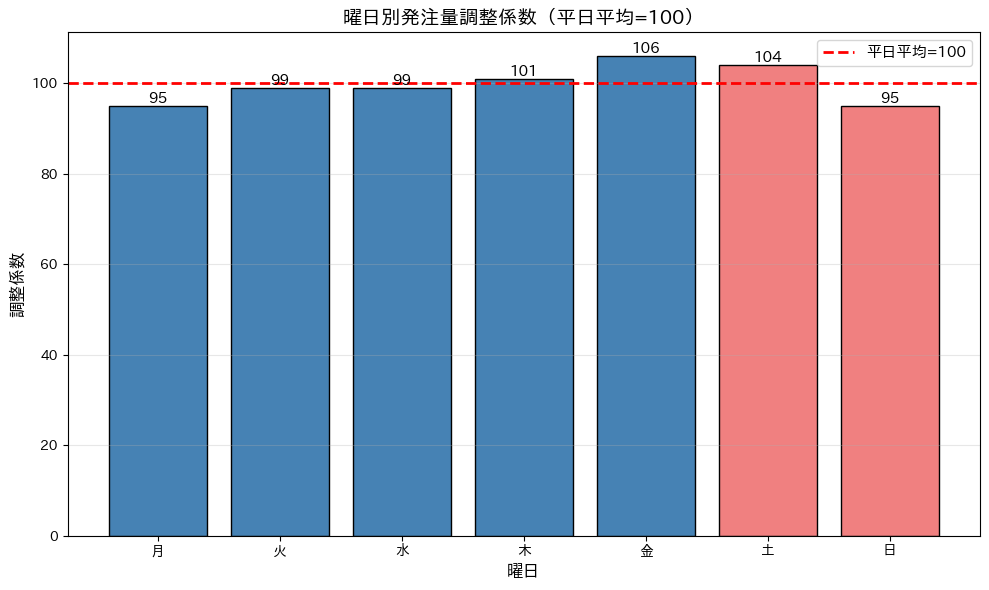

In [7]:
# 曜日別発注量調整係数のグラフ
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['lightcoral' if day in ['土', '日'] else 'steelblue' for day in weekday_order]
ax.bar(weekday_order, weekday_index.values, color=colors, edgecolor='black')
ax.axhline(y=100, color='red', linestyle='--', linewidth=2, label='平日平均=100')
ax.set_title('曜日別発注量調整係数（平日平均=100）', fontsize=14, fontproperties=JP_FP)
ax.set_xlabel('曜日', fontsize=12, fontproperties=JP_FP)
ax.set_ylabel('調整係数', fontsize=12, fontproperties=JP_FP)
ax.legend(fontsize=11, prop=JP_FP)
ax.grid(axis='y', alpha=0.3)

for i, (day, val) in enumerate(zip(weekday_order, weekday_index.values)):
    ax.text(i, val, f'{val:.0f}', ha='center', va='bottom', fontsize=11, fontproperties=JP_FP)

plt.tight_layout()
plt.show()

## 📈 6. 需要予測（移動平均法）

### 業務的な意義
過去のデータから未来の需要を予測し、先手を打った発注をする

### 移動平均法とは？
直近N日間の平均を次の日の予測値とする方法（シンプルだが実用的）

📈 需要予測デモ商品: い・ろ・は・す５４０


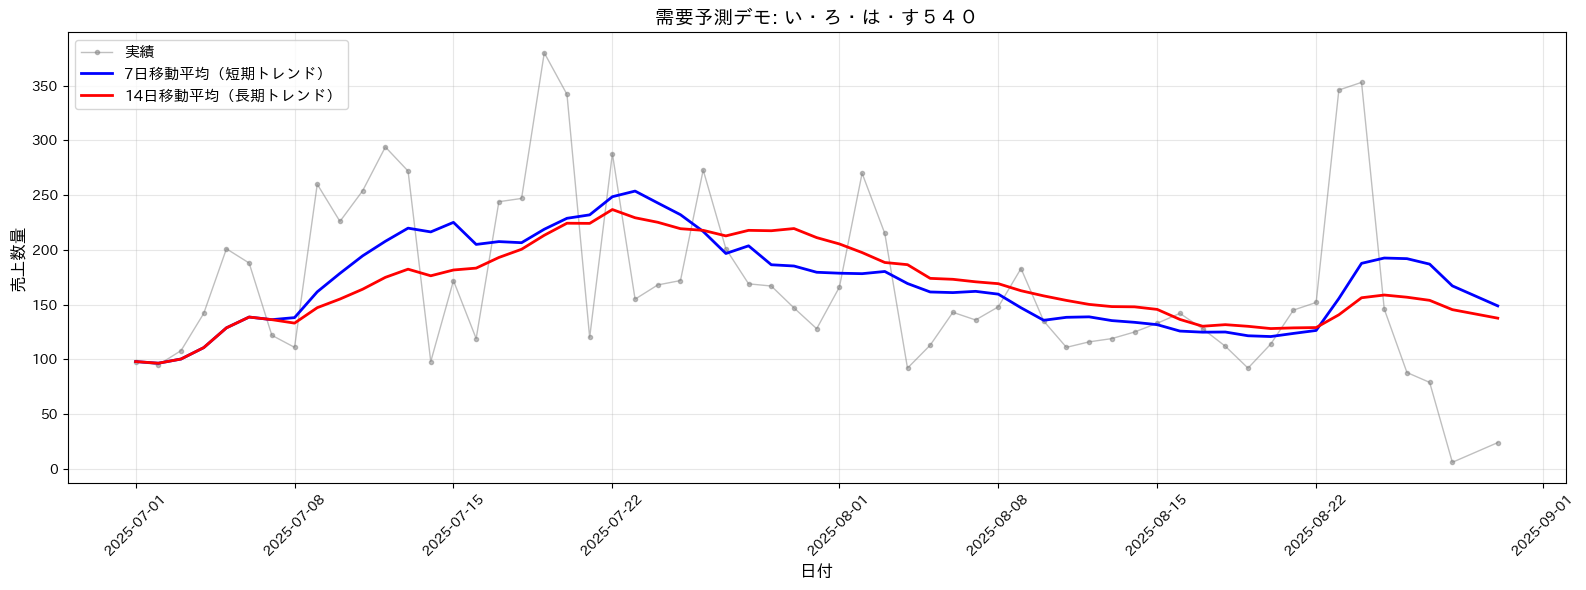


💡 移動平均の使い方
  ✓ 7日移動平均: 直近の短期トレンドを捉える（急な変化に対応）
  ✓ 14日移動平均: 長期的な傾向を捉える（安定したトレンド）
  ✓ 翌日の予測値 = 最新の移動平均値


In [8]:
# 代表的な商品（売上上位）を選択
top_product = product_stats.sort_values('平均', ascending=False).iloc[0]['商品名']

print(f"📈 需要予測デモ商品: {top_product}")

# その商品の日次売上データ
product_daily = daily_product_sales[daily_product_sales['商品名'] == top_product].copy()
product_daily = product_daily.sort_values('日付')

# 7日移動平均
product_daily['予測_7日移動平均'] = product_daily['売上数量'].rolling(window=7, min_periods=1).mean()

# 14日移動平均
product_daily['予測_14日移動平均'] = product_daily['売上数量'].rolling(window=14, min_periods=1).mean()

# グラフ化
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(product_daily['日付'], product_daily['売上数量'], 
        alpha=0.5, color='gray', linewidth=1, marker='o', markersize=3, label='実績')
ax.plot(product_daily['日付'], product_daily['予測_7日移動平均'], 
        color='blue', linewidth=2, label='7日移動平均（短期トレンド）')
ax.plot(product_daily['日付'], product_daily['予測_14日移動平均'], 
        color='red', linewidth=2, label='14日移動平均（長期トレンド）')

ax.set_title(f'需要予測デモ: {top_product}', fontsize=14, fontproperties=JP_FP)
ax.set_xlabel('日付', fontsize=12, fontproperties=JP_FP)
ax.set_ylabel('売上数量', fontsize=12, fontproperties=JP_FP)
ax.legend(fontsize=11, prop=JP_FP)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n💡 移動平均の使い方")
print("  ✓ 7日移動平均: 直近の短期トレンドを捉える（急な変化に対応）")
print("  ✓ 14日移動平均: 長期的な傾向を捉える（安定したトレンド）")
print("  ✓ 翌日の予測値 = 最新の移動平均値")

## 🎯 7. 主要商品の発注推奨レポート

### 業務的な活用
このレポートを見ながら、実際の発注作業を行う

In [9]:
# 上位50商品の発注推奨レポート
top50_products = product_stats.sort_values('平均', ascending=False).head(50).copy()

# 曜日別の推奨発注量を追加
for day in weekday_order:
    day_index = weekday_index[day]
    top50_products[f'{day}曜発注量'] = (top50_products['推奨発注量_週間'] / 7 * day_index / 100).round(0)

print("="*60)
print("🎯 主要商品発注推奨レポート（上位50商品）")
print("="*60)
print("\n【基本パラメータ】")
print(top50_products[['商品名', '平均', '安全在庫', '発注点', '需要パターン']].head(20).to_string(index=False))

print("\n\n【曜日別推奨発注量（上位10商品のみ表示）】")
weekday_cols = [f'{day}曜発注量' for day in weekday_order]
print(top50_products[['商品名'] + weekday_cols].head(10).to_string(index=False))

🎯 主要商品発注推奨レポート（上位50商品）

【基本パラメータ】
                  商品名       平均  安全在庫  発注点 需要パターン
    い・ろ・は・す５４０ 168.216667     131.0   299.0         通常
  ポケカ拡張インフェルノ 156.500000     385.0   542.0       変動大
                  レジ袋 138.967391      38.0   177.0         安定
サントリー天然水　５５０ 134.702703      65.0   200.0         安定
     ◎ジャスミン茶６００ 116.619565      53.0   170.0         安定
             ◎緑茶６００ 100.760870      57.0   158.0         通常
 ◎天然水新潟県津南６００  78.554348      38.0   117.0         通常
          直巻　焼しゃけ  70.304348      43.0   113.0         通常
直巻　和風ツナマヨネーズ  69.130435      45.0   114.0         通常
      健康ミネラルむぎ茶  59.591549      81.0   141.0       変動大
手巻シーチキンマヨネーズ  58.021739      29.0    87.0         通常
  ポケカ拡張メガブレイブ  57.416667      87.0   144.0       変動大
  レジ袋１２号バイオマス  57.054348      18.0    75.0         安定
午後フルーツティ白ぶどう  55.666667      35.0    91.0         通常
  ポケカ拡張メガシンフォ  52.923077      74.0   127.0       変動大
 ◎アップル香るジャスミン  52.010870      68.0   120.0       変動大
    高菜たくあんおむすび  51.861111      39.0    

## ⚠️ 8. 発注アラート機能

### 業務的な意義
- **過剰発注アラート**: 廃棄リスクが高い商品
- **欠品リスクアラート**: 安全在庫を下回りそうな商品

※ 実際の在庫データがないため、デモとして需要変動が大きい商品をアラート対象とします

In [10]:
# 需要変動が大きい商品（発注難易度が高い）
high_variance_products = product_stats[
    (product_stats['需要パターン'] == '変動大') &
    (product_stats['平均'] >= 5)  # 平均売上が5個以上の商品に絞る
].sort_values('変動係数_CV', ascending=False)

print("="*60)
print("⚠️ 発注注意商品（需要変動が大きい）")
print("="*60)
print(f"\n該当商品数: {len(high_variance_products)}商品")
print("\n【発注注意が必要な商品TOP20】")
print(high_variance_products.head(20)[['商品名', '平均', '標準偏差', '変動係数_CV', '安全在庫', '発注点']].to_string(index=False))

print("\n" + "-"*60)
print("【業務的なアクション】")
print("  1. これらの商品は需要予測が難しいため、慎重に発注する")
print("  2. 安全在庫を多めに確保し、欠品を防ぐ")
print("  3. 曜日・イベント・天気との相関を分析し、パターンを見つける")
print("  4. 過剰在庫になりやすいため、廃棄リスクに注意")

⚠️ 発注注意商品（需要変動が大きい）

該当商品数: 106商品

【発注注意が必要な商品TOP20】
                  商品名       平均   標準偏差  変動係数_CV  安全在庫  発注点
        その他３口座売上  13.294118  21.200721         1.59      35.0    48.0
              ブレンドＳ  40.306452  63.983499         1.59     105.0   145.0
  ポケカ拡張インフェルノ 156.500000 234.118916         1.50     385.0   542.0
        週刊少年ジャンプ   6.574468   8.566225         1.30      14.0    21.0
ライオンコーヒーブラック   9.500000  12.020815         1.27      20.0    30.0
        漬けぶりおむすび   9.000000  11.313708         1.26      19.0    28.0
 ◎ハムチーズクロワッサン   9.277778  10.980973         1.18      18.0    27.0
たっぷりコーンマヨネーズ   6.000000   7.071068         1.18      12.0    18.0
      ガルボ紫いもＰＫＰ   5.500000   6.363961         1.16      10.0    16.0
メガライフガード　７００   6.666667   7.593857         1.14      12.0    19.0
      天然水きりっとヨグ  15.659574  16.719263         1.07      28.0    44.0
ライオンコーヒカフェオレ   8.000000   8.485281         1.06      14.0    22.0
専炭治郎の抹茶クリームロ   9.428571   9.669256         1.03      16.0    25.0
専胡蝶し

## 💾 9. 発注最適化結果の保存

In [11]:
# 出力ディレクトリ
output_dir = Path('output/stage3_order_optimization')
output_dir.mkdir(parents=True, exist_ok=True)

# 商品別発注パラメータ（全商品）
product_stats.to_csv(output_dir / '商品別発注パラメータ.csv', index=False, encoding='utf-8-sig')

# 上位50商品の曜日別発注量
top50_products.to_csv(output_dir / '主要商品曜日別発注量.csv', index=False, encoding='utf-8-sig')

# 曜日別調整係数
weekday_df.to_csv(output_dir / '曜日別発注量調整係数.csv', index=False, encoding='utf-8-sig')

# 発注注意商品リスト
high_variance_products.to_csv(output_dir / '発注注意商品リスト.csv', index=False, encoding='utf-8-sig')

print("✅ 発注最適化結果を保存しました:")
print(f"   {output_dir}/")
print("\n📋 保存ファイル:")
print("  - 商品別発注パラメータ.csv")
print("  - 主要商品曜日別発注量.csv")
print("  - 曜日別発注量調整係数.csv")
print("  - 発注注意商品リスト.csv")

✅ 発注最適化結果を保存しました:
   output/stage3_order_optimization/

📋 保存ファイル:
  - 商品別発注パラメータ.csv
  - 主要商品曜日別発注量.csv
  - 曜日別発注量調整係数.csv
  - 発注注意商品リスト.csv


## 💡 10. Stage 3 まとめ

### 発注最適化で分かったこと
1. **安全在庫**: 欠品を防ぐ最低限の在庫量
2. **発注点**: この水準を下回ったら発注するタイミング
3. **推奨発注量**: 週次で発注すべき標準量
4. **曜日別調整**: 需要変動に応じた発注量の調整
5. **需要予測**: 移動平均法で翌日の需要を予測

### 実務での活用方法
```
【発注フロー】
1. 現在の在庫をチェック
2. 在庫が「発注点」を下回っているか確認
3. 下回っていたら、「曜日別発注量」を参考に発注
4. 「安全在庫」を常に確保する
5. 「発注注意商品」は慎重に発注
```

### 次のステップ
- **Stage 4**: 外部要因分析（天気・イベントの影響を理解）
- **Stage 5**: PyCaretで高度な需要予測モデルを構築

---